# Point cloud classification with Pointnet using Keras


## Introduction

Classification of unordered 3D point sets i.e. point clouds
is a core problem in computer vision. This example implements the seminal point cloud
deep learning paper [PointNet (Qi et al., 2017)](https://arxiv.org/abs/1612.00593) for a synthetic dataset. 


## Setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2023-11-07 18:04:00.294023: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 18:04:01.600304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras import callbacks

from DataSetsLoader import DataSetsLoader
from OrthogonalRegularizer import OrthogonalRegularizer

tf.random.set_seed(123)


## Load dataset

We use the Dublin synthetic dataset, there are 3 major classes taken in consideration namely building, trees and roads/ground.


Set the number of points to sample and batch size and parse the dataset.

In [3]:
NUM_POINTS = 4096
NUM_CLASSES = 3
BATCH_SIZE = 32

In [4]:
# Load Datasets
datasets_loader = DataSetsLoader(NUM_POINTS,NUM_CLASSES)
train_points, test_points, val_points, train_labels, test_labels, val_labels = datasets_loader.transform_to_tensorflow_dataset()

In [5]:
#Check for any Nans
import math
np.argwhere(np.isnan(train_points))

array([], shape=(0, 3), dtype=int64)

In [6]:
def label_mapping(lbl):
    if(lbl.lower() == 'b'):
        return 0
    if(lbl.lower() == 'g'):
        return 1
    if(lbl.lower() == 'v'):
        return 2
    else:
        return None

In [7]:
train_label=[]
test_label=[]
val_label=[]
for i in train_labels:
    label_train = label_mapping(i.lower())
    if(label_train!=None):
        train_label.append(label_train)
        
for j in test_labels:  
    label_tst = label_mapping(j.lower())
    if(label_tst!=None):
        test_label.append(label_tst)

for k in val_labels:  
    label_val = label_mapping(k.lower())
    if(label_val!=None):
        val_label.append(label_val)
        
# train_label = tf.one_hot(train_label, depth=3)       
# test_label = tf.one_hot(test_label, depth=3)

print(train_label)    
print(test_label)
print(val_label)    

[1, 1, 2, 0, 2, 1, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 2, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 2, 2, 0, 2, 1, 1, 1, 0, 0, 2, 0, 1, 2, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 0, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 1, 

Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer size to the entire size of the dataset as prior to this the data is ordered by class. Data augmentation is important when working with point cloud data. We create a augmentation function to jitter and shuffle the train dataset.


In [8]:

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_points, val_label))

# train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
# val_dataset = val_dataset.shuffle(len(val_points)).batch(BATCH_SIZE)
# test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = train_dataset.map(augment).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

2023-11-07 18:04:29.703462: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.


PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).

In [9]:

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)



In [10]:
# class OrthogonalRegularizer(keras.regularizers.Regularizer):
#     def __init__(self, num_features, l2reg=0.001):        
#         self.num_features = num_features
#         self.l2reg = l2reg
#         self.eye = tf.eye(num_features)        

#     # gets called at each train iteration
#     def __call__(self, x): # your custom function here
#         x = tf.reshape(x, (-1, self.num_features, self.num_features))
#         xxt = tf.tensordot(x, x, axes=(2, 2))
#         xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
#         return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

#     def get_config(self): # required class method
#         return {"num_features": self.num_features,
#                 "l2reg": self.l2reg}
    
# cl_test = OrthogonalRegularizer(3) 
# config_test_cl = cl_test.get_config() 
# print(config_test_cl) 
# cl_test_ = OrthogonalRegularizer.from_config(config_test_cl)


### tnet layer function

 We can then define a general function to build T-net layers, similar to fig: 
 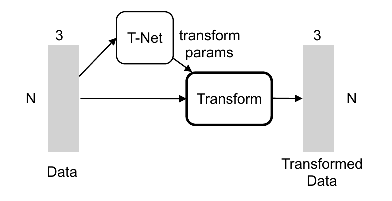

---




In [11]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



### Variable learning rate

The main network can be then implemented in the same manner where the t-net mini models can be dropped in a layers in the graph. Here I replicate the network architecture published in the original paper but with half the number of weights at each layer as I am using the smaller Dublin dataset.


In [12]:
initial_learning_rate = 0.001    
decay_steps = 7000  #200000
decay_rate = 0.7
# MOMENTUM = 0.99
def get_learning_rate(initial_learning_rate,decay_steps, decay_rate):
    
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False, name=None)
    return learning_rate 

### Create model


In [13]:
def create_model():
    inputs = keras.Input(shape=(NUM_POINTS, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    return model

model = create_model()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(get_learning_rate(initial_learning_rate,decay_steps, decay_rate)),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4096, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 4096, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 4096, 32)             0         ['batch_normalization[0

### Train model

In [14]:
checkpoint_path = 'my_final_model_save'
es = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, start_from_epoch = 100, patience = 3)
mc = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_dataset, epochs=150, validation_data=val_dataset, callbacks = [es,mc])

Epoch 1/150
12/12 [==============================] - ETA: 0s - loss: 2.8935 - sparse_categorical_accuracy: 0.6094
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.45385, saving model to my_final_model_save
INFO:tensorflow:Assets written to: my_final_model_save/assets


INFO:tensorflow:Assets written to: my_final_model_save/assets


12/12 [==============================] - 68s 5s/step - loss: 2.8935 - sparse_categorical_accuracy: 0.6094 - val_loss: 2.9967 - val_sparse_categorical_accuracy: 0.4538
Epoch 2/150
12/12 [==============================] - ETA: 0s - loss: 2.2931 - sparse_categorical_accuracy: 0.7682
Epoch 2: val_sparse_categorical_accuracy improved from 0.45385 to 0.57692, saving model to my_final_model_save
INFO:tensorflow:Assets written to: my_final_model_save/assets


INFO:tensorflow:Assets written to: my_final_model_save/assets


12/12 [==============================] - 55s 5s/step - loss: 2.2931 - sparse_categorical_accuracy: 0.7682 - val_loss: 2.7086 - val_sparse_categorical_accuracy: 0.5769
Epoch 3/150
12/12 [==============================] - ETA: 0s - loss: 1.9660 - sparse_categorical_accuracy: 0.7708
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.57692
12/12 [==============================] - 45s 4s/step - loss: 1.9660 - sparse_categorical_accuracy: 0.7708 - val_loss: 2.6723 - val_sparse_categorical_accuracy: 0.4923
Epoch 4/150
12/12 [==============================] - ETA: 0s - loss: 1.8721 - sparse_categorical_accuracy: 0.7500
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.57692
12/12 [==============================] - 44s 4s/step - loss: 1.8721 - sparse_categorical_accuracy: 0.7500 - val_loss: 2.2650 - val_sparse_categorical_accuracy: 0.4538
Epoch 5/150
12/12 [==============================] - ETA: 0s - loss: 1.7926 - sparse_categorical_accuracy: 0.7865
Epoch 5: val_spar

INFO:tensorflow:Assets written to: my_final_model_save/assets


12/12 [==============================] - 62s 5s/step - loss: 1.1992 - sparse_categorical_accuracy: 0.9714 - val_loss: 3.0082 - val_sparse_categorical_accuracy: 0.6000
Epoch 34/150
12/12 [==============================] - ETA: 0s - loss: 1.2054 - sparse_categorical_accuracy: 0.9531
Epoch 34: val_sparse_categorical_accuracy did not improve from 0.60000
12/12 [==============================] - 49s 4s/step - loss: 1.2054 - sparse_categorical_accuracy: 0.9531 - val_loss: 2.9570 - val_sparse_categorical_accuracy: 0.5769
Epoch 35/150
12/12 [==============================] - ETA: 0s - loss: 1.2320 - sparse_categorical_accuracy: 0.9453
Epoch 35: val_sparse_categorical_accuracy did not improve from 0.60000
12/12 [==============================] - 51s 4s/step - loss: 1.2320 - sparse_categorical_accuracy: 0.9453 - val_loss: 2.4201 - val_sparse_categorical_accuracy: 0.6000
Epoch 36/150
12/12 [==============================] - ETA: 0s - loss: 1.2486 - sparse_categorical_accuracy: 0.9479
Epoch 36: va

INFO:tensorflow:Assets written to: my_final_model_save/assets


12/12 [==============================] - 64s 5s/step - loss: 1.2851 - sparse_categorical_accuracy: 0.9427 - val_loss: 2.7225 - val_sparse_categorical_accuracy: 0.6615
Epoch 38/150
12/12 [==============================] - ETA: 0s - loss: 1.2624 - sparse_categorical_accuracy: 0.9505
Epoch 38: val_sparse_categorical_accuracy did not improve from 0.66154
12/12 [==============================] - 51s 4s/step - loss: 1.2624 - sparse_categorical_accuracy: 0.9505 - val_loss: 2.8194 - val_sparse_categorical_accuracy: 0.5077
Epoch 39/150
12/12 [==============================] - ETA: 0s - loss: 1.2153 - sparse_categorical_accuracy: 0.9583
Epoch 39: val_sparse_categorical_accuracy did not improve from 0.66154
12/12 [==============================] - 49s 4s/step - loss: 1.2153 - sparse_categorical_accuracy: 0.9583 - val_loss: 2.4281 - val_sparse_categorical_accuracy: 0.6538
Epoch 40/150
12/12 [==============================] - ETA: 0s - loss: 1.1879 - sparse_categorical_accuracy: 0.9661
Epoch 40: va

INFO:tensorflow:Assets written to: my_final_model_save/assets


12/12 [==============================] - 62s 5s/step - loss: 1.2475 - sparse_categorical_accuracy: 0.9557 - val_loss: 2.7912 - val_sparse_categorical_accuracy: 0.7154
Epoch 45/150
12/12 [==============================] - ETA: 0s - loss: 1.2111 - sparse_categorical_accuracy: 0.9583
Epoch 45: val_sparse_categorical_accuracy did not improve from 0.71538
12/12 [==============================] - 52s 4s/step - loss: 1.2111 - sparse_categorical_accuracy: 0.9583 - val_loss: 2.2305 - val_sparse_categorical_accuracy: 0.6692
Epoch 46/150
12/12 [==============================] - ETA: 0s - loss: 1.1757 - sparse_categorical_accuracy: 0.9792
Epoch 46: val_sparse_categorical_accuracy did not improve from 0.71538
12/12 [==============================] - 49s 4s/step - loss: 1.1757 - sparse_categorical_accuracy: 0.9792 - val_loss: 2.6445 - val_sparse_categorical_accuracy: 0.6385
Epoch 47/150
12/12 [==============================] - ETA: 0s - loss: 1.2618 - sparse_categorical_accuracy: 0.9453
Epoch 47: va

INFO:tensorflow:Assets written to: my_final_model_save/assets


12/12 [==============================] - 64s 5s/step - loss: 1.1586 - sparse_categorical_accuracy: 0.9740 - val_loss: 2.3456 - val_sparse_categorical_accuracy: 0.7462
Epoch 62/150
12/12 [==============================] - ETA: 0s - loss: 1.1157 - sparse_categorical_accuracy: 0.9870
Epoch 62: val_sparse_categorical_accuracy did not improve from 0.74615
12/12 [==============================] - 51s 4s/step - loss: 1.1157 - sparse_categorical_accuracy: 0.9870 - val_loss: 2.3317 - val_sparse_categorical_accuracy: 0.6538
Epoch 63/150
12/12 [==============================] - ETA: 0s - loss: 1.0725 - sparse_categorical_accuracy: 1.0000
Epoch 63: val_sparse_categorical_accuracy did not improve from 0.74615
12/12 [==============================] - 51s 4s/step - loss: 1.0725 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.5993 - val_sparse_categorical_accuracy: 0.6000
Epoch 64/150
12/12 [==============================] - ETA: 0s - loss: 1.0706 - sparse_categorical_accuracy: 0.9974
Epoch 64: va

INFO:tensorflow:Assets written to: my_final_model_save/assets


12/12 [==============================] - 60s 5s/step - loss: 1.1907 - sparse_categorical_accuracy: 0.9661 - val_loss: 6.3067 - val_sparse_categorical_accuracy: 0.7692
Epoch 75/150
12/12 [==============================] - ETA: 0s - loss: 1.2902 - sparse_categorical_accuracy: 0.9479
Epoch 75: val_sparse_categorical_accuracy improved from 0.76923 to 0.79231, saving model to my_final_model_save
INFO:tensorflow:Assets written to: my_final_model_save/assets


INFO:tensorflow:Assets written to: my_final_model_save/assets


12/12 [==============================] - 59s 5s/step - loss: 1.2902 - sparse_categorical_accuracy: 0.9479 - val_loss: 6.3997 - val_sparse_categorical_accuracy: 0.7923
Epoch 76/150
12/12 [==============================] - ETA: 0s - loss: 1.2184 - sparse_categorical_accuracy: 0.9557
Epoch 76: val_sparse_categorical_accuracy did not improve from 0.79231
12/12 [==============================] - 48s 4s/step - loss: 1.2184 - sparse_categorical_accuracy: 0.9557 - val_loss: 6.2819 - val_sparse_categorical_accuracy: 0.7769
Epoch 77/150
12/12 [==============================] - ETA: 0s - loss: 1.1543 - sparse_categorical_accuracy: 0.9870
Epoch 77: val_sparse_categorical_accuracy did not improve from 0.79231
12/12 [==============================] - 48s 4s/step - loss: 1.1543 - sparse_categorical_accuracy: 0.9870 - val_loss: 3.7565 - val_sparse_categorical_accuracy: 0.7231
Epoch 78/150
12/12 [==============================] - ETA: 0s - loss: 1.1474 - sparse_categorical_accuracy: 0.9896
Epoch 78: va

## Training Loss Graph

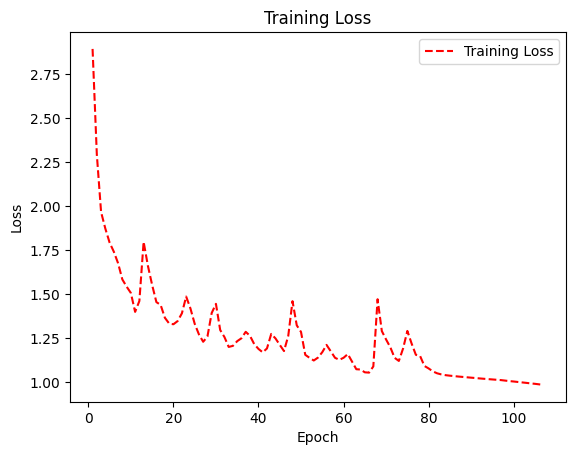

In [15]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
# plt.plot(epoch_count, val_loss, 'b-')
plt.title('Training Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Validation Loss Graph

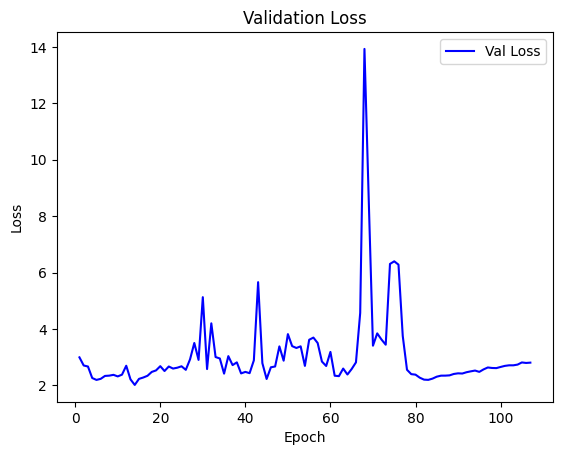

In [16]:
epoch_count = range(1, len(training_loss)+1)

plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Val Loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Model Accuracy Graph

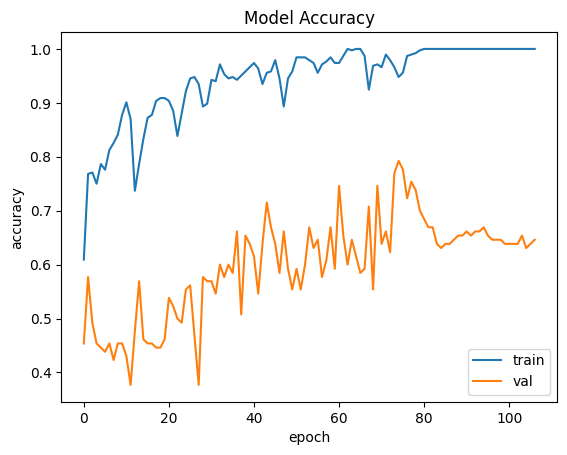

In [17]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Model output after 107 epochs

The model was run for 150 epochs, because of early stopping, the model training was stopped at 107 epochs. But the accuracy achieved on both training and validation was less than values in prior epochs. So the model was saved when the validation accuracy was at its peak.
The results below are early stopping results:

## Visualize predictions

1/1 [==============================] - 1s 846ms/step


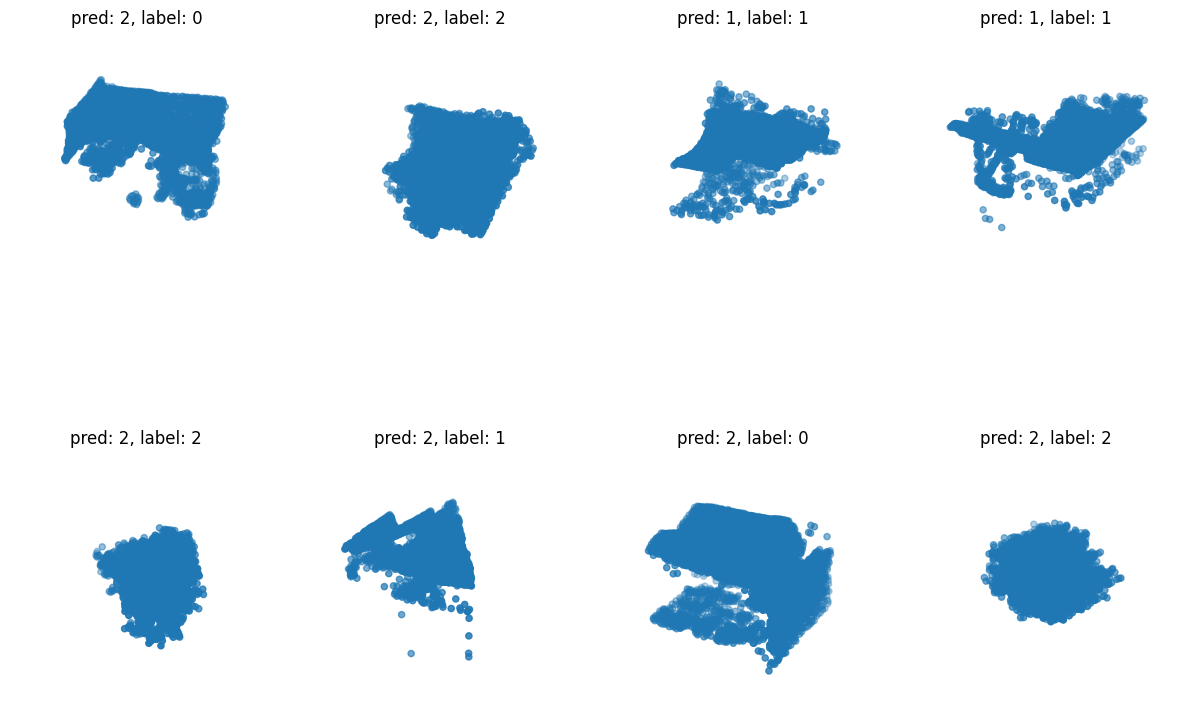

In [18]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(preds[i].numpy(),labels.numpy()[i])
    )
    ax.set_axis_off()
plt.show()


In [19]:
dataset = test_dataset
total_count = 0
correct_count = 0
expected = []
predicted = []
accuracy_arr = []

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        predicted.append(pred[index])
        expected.append(labels[index])
        if labels[index] == pred[index]:
            correct_count += 1
        
        accuracy  = correct_count / total_count
        print("Accuracy  is {}".format(accuracy))
        accuracy_arr.append(accuracy)
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 1s 632ms/step
Accuracy  is 0.0
1/1 [==============================] - 1s 627ms/step
Accuracy  is 0.5
1/1 [==============================] - 1s 707ms/step
Accuracy  is 0.6666666666666666
1/1 [==============================] - 1s 692ms/step
Accuracy  is 0.75
1/1 [==============================] - 1s 704ms/step
Accuracy  is 0.8
1/1 [==============================] - 1s 646ms/step
Accuracy  is 0.6666666666666666
1/1 [==============================] - 1s 664ms/step
Accuracy  is 0.5714285714285714
1/1 [==============================] - 1s 609ms/step
Accuracy  is 0.625
1/1 [==============================] - 1s 626ms/step
Accuracy  is 0.6666666666666666
1/1 [==============================] - 1s 593ms/step
Accuracy  is 0.6
1/1 [==============================] - 1s 650ms/step
Accuracy  is 0.6363636363636364
1/1 [==============================] - 1s 685ms/step
Accuracy  is 0.5833333333333334
1/1 [==============================] - 1s 630ms/step
Accuracy  is 0

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [21]:
label_names = np.array(['building','ground','vegetation'])

## Confusion Matrix

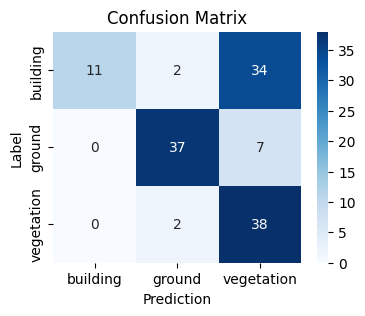

Accuracy: 0.656489
Precision: 0.656489
Recall: 0.656489
F1 score: 0.656489
              precision    recall  f1-score   support

    building       1.00      0.23      0.38        47
      ground       0.90      0.84      0.87        44
  vegetation       0.48      0.95      0.64        40

    accuracy                           0.66       131
   macro avg       0.79      0.67      0.63       131
weighted avg       0.81      0.66      0.62       131



In [22]:
confusion_mtx = tf.math.confusion_matrix(expected, predicted)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g',cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

accuracy = accuracy_score(expected, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)  58/(58+6)  : was something else but predicted b,g,v
precision = precision_score(expected, predicted, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)   58/(58+6)  : was b,g,v but predicted as something else
recall = recall_score(expected, predicted, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)  2*58/(2*58+6+6)
f1 = f1_score(expected, predicted, average='micro')
print('F1 score: %f' % f1)

print(classification_report(expected, predicted,target_names=label_names))


# Saved model output

The results below are best model saved results:

In [23]:
saved_model = create_model()
saved_model.load_weights(checkpoint_path)

2023-11-07 19:34:43.144241: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open my_final_model_save: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?


1/1 [==============================] - 1s 948ms/step


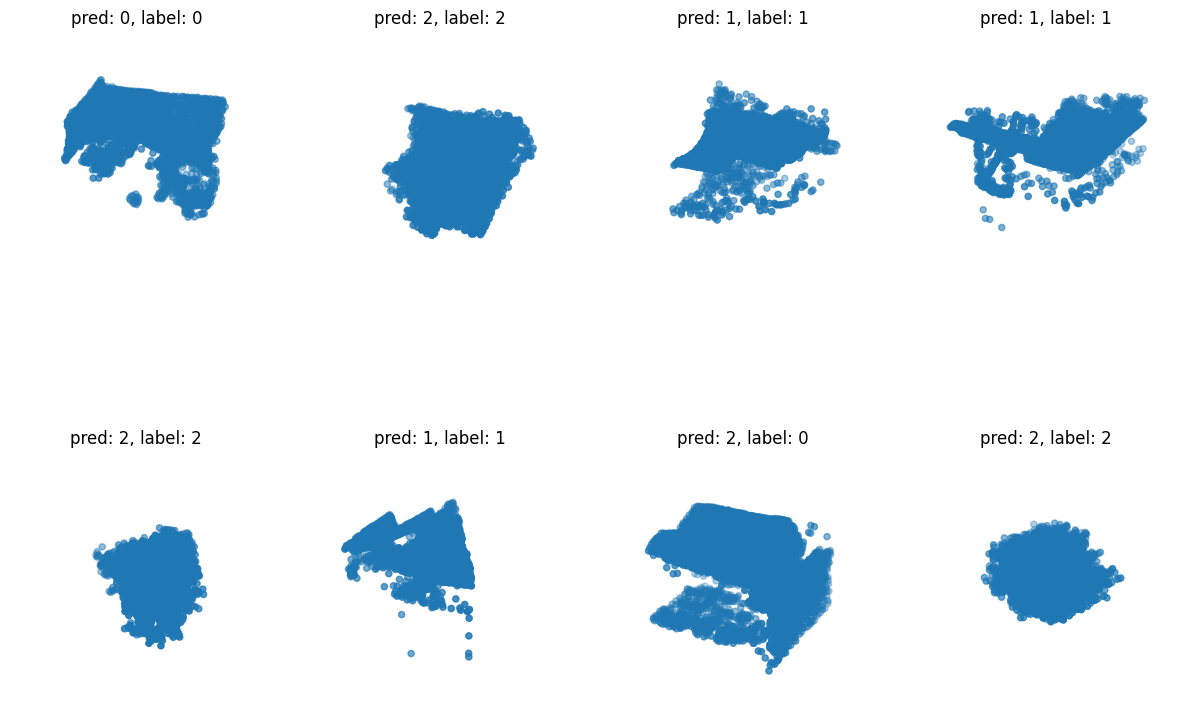

In [24]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = saved_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(preds[i].numpy(),labels.numpy()[i])
    )
    ax.set_axis_off()
plt.show()


# Test dataset predictions

In [25]:
dataset = test_dataset
total_count = 0
correct_count = 0
expected = []
predicted = []
accuracy_arr = []

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = saved_model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = saved_model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        predicted.append(pred[index])
        expected.append(labels[index])
        if labels[index] == pred[index]:
            correct_count += 1
        
        accuracy  = correct_count / total_count
        print("Accuracy  is {}".format(accuracy))
        accuracy_arr.append(accuracy)
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 1s 647ms/step
Accuracy  is 1.0
1/1 [==============================] - 1s 655ms/step
Accuracy  is 1.0
1/1 [==============================] - 1s 625ms/step
Accuracy  is 1.0
1/1 [==============================] - 1s 668ms/step
Accuracy  is 1.0
1/1 [==============================] - 1s 587ms/step
Accuracy  is 1.0
1/1 [==============================] - 1s 684ms/step
Accuracy  is 1.0
1/1 [==============================] - 1s 675ms/step
Accuracy  is 0.8571428571428571
1/1 [==============================] - 1s 715ms/step
Accuracy  is 0.875
1/1 [==============================] - 1s 554ms/step
Accuracy  is 0.8888888888888888
1/1 [==============================] - 1s 675ms/step
Accuracy  is 0.9
1/1 [==============================] - 1s 706ms/step
Accuracy  is 0.9090909090909091
1/1 [==============================] - 1s 609ms/step
Accuracy  is 0.8333333333333334
1/1 [==============================] - 1s 697ms/step
Accuracy  is 0.7692307692307693
1/1 [========

In [26]:
label_names = np.array(['building','ground','vegetation'])

## Confusion Matrix

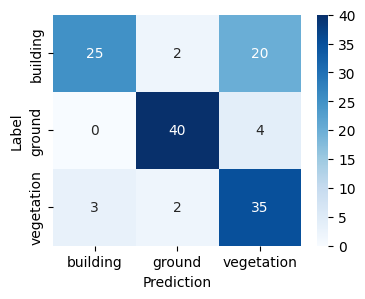

Accuracy: 0.763359
Precision: 0.763359
Recall: 0.763359
F1 score: 0.763359
              precision    recall  f1-score   support

    building       0.89      0.53      0.67        47
      ground       0.91      0.91      0.91        44
  vegetation       0.59      0.88      0.71        40

    accuracy                           0.76       131
   macro avg       0.80      0.77      0.76       131
weighted avg       0.81      0.76      0.76       131



In [27]:
confusion_mtx = tf.math.confusion_matrix(expected, predicted)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g',cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

accuracy = accuracy_score(expected, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)  58/(58+6)  : was something else but predicted b,g,v
precision = precision_score(expected, predicted, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)   58/(58+6)  : was b,g,v but predicted as something else
recall = recall_score(expected, predicted, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)  2*58/(2*58+6+6)
f1 = f1_score(expected, predicted, average='micro')
print('F1 score: %f' % f1)

print(classification_report(expected, predicted,target_names=label_names))
